# 02 - Generating Dataset 1

The purpose of this notebook is to explore the dataset created by [02_generate_dataset.ipynb](02_generate_dataset.ipynb)

In [2]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [3]:
import json
import os
import sys

# This will add the src directory to sys.path
# meaning that the privacy_fingerprint will be found
# note it assumes the current working directory is the folder containing this notebook
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'/src')

In [4]:
# The Synthea output was saved to a directory
output_dir = "../experiments/02_generate_dataset"
os.makedirs(output_dir, exist_ok=True)
export_directory = os.path.join(output_dir, "synthea")

## Load the data and save a dataset of long visits

The Synthea dataset only saves records of the type specified in expt_config.synthea.encounter_type at the time the experiment was run. Not that useful here

In [5]:

# with open(os.path.join(output_dir, "synthea_dataset.json")) as fp:
#     synthea_records = json.load(fp)

# len(synthea_records)

In [6]:
import pandas as pd
enc = pd.read_csv('../experiments/02_generate_dataset/synthea/csv/encounters.csv')
pat = pd.read_csv('../experiments/02_generate_dataset/synthea/csv/patients.csv')
cond = pd.read_csv('../experiments/02_generate_dataset/synthea/csv/conditions.csv')
med = pd.read_csv('../experiments/02_generate_dataset/synthea/csv/medications.csv')
proc = pd.read_csv('../experiments/02_generate_dataset/synthea/csv/procedures.csv')

In [7]:
# Convert START and STOP to datetime
enc['START'] = pd.to_datetime(enc['START'])
enc['STOP'] = pd.to_datetime(enc['STOP'])

# Calculate time difference
enc['DURATION'] = enc['STOP'] - enc['START']

In [9]:
enc.ENCOUNTERCLASS.value_counts()

ENCOUNTERCLASS
ambulatory    3526
wellness      2051
outpatient    1121
emergency      482
urgentcare     100
inpatient       92
hospice         22
home            21
snf             17
virtual          5
Name: count, dtype: int64

In [7]:
print("Number of unique patients with hospital inpatient")
print(len(enc[enc.ENCOUNTERCLASS == 'inpatient']['PATIENT'].unique()))
enc[enc.ENCOUNTERCLASS == 'inpatient']['DESCRIPTION'].value_counts()

Number of unique patients with hospital inpatient
41


DESCRIPTION
Drug rehabilitation and detoxification                 41
Admission to intensive care unit (procedure)           13
Hospital admission (procedure)                          9
Encounter for problem (procedure)                       6
Admission to ward (procedure)                           5
Admission to surgical department                        3
Hospital admission for isolation (procedure)            3
Patient transfer to intensive care unit (procedure)     2
Admission to thoracic surgery department                2
Non-urgent orthopedic admission                         2
Follow-up visit (procedure)                             2
Encounter for problem                                   2
Encounter Inpatient                                     1
Hospital admission  for observation (procedure)         1
Name: count, dtype: int64

In [13]:
print("Number of unique patients with emergency visit")
# print(len(enc[enc.ENCOUNTERCLASS == 'inpatient']['PATIENT'].unique()))
enc[enc.ENCOUNTERCLASS == 'emergency']['DESCRIPTION'].value_counts()

Number of unique patients with emergency visit


DESCRIPTION
Emergency treatment (procedure)            253
Emergency room admission (procedure)       145
Obstetric emergency hospital admission      35
Emergency Encounter                         23
Encounter for Problem                       10
Encounter for problem                        7
Emergency hospital admission for asthma      6
Emergency Room Admission                     3
Name: count, dtype: int64

In [16]:
# all inpatient visits

files_to_process = []
unique_pats_with_inpatient_visit = enc[enc.ENCOUNTERCLASS == 'inpatient']['PATIENT'].unique()
print(len(unique_pats_with_inpatient_visit))

for patient_id in unique_pats_with_inpatient_visit:
    for file_name in os.listdir('../experiments/02_generate_dataset/synthea/fhir'):
        if patient_id in file_name:
            files_to_process.append(file_name)

            
all_fhir_files = []
for file_name in os.listdir('../experiments/02_generate_dataset/synthea/fhir'):
    all_fhir_files.append(file_name)

len(all_fhir_files)

41


67215

In [11]:
# # Longest 20 visits
# long_visits = enc.sort_values('DURATION', ascending=False).head(20)['PATIENT'].unique()

# files_to_process = []

# for patient_id in all_visits: #long_visits:
#     for file_name in os.listdir('../experiments/02_generate_dataset/synthea/fhir'):
#         if patient_id in file_name:
#             files_to_process.append(file_name)

# print(len(files_to_process))


In [13]:
# Could also include these

# files = os.listdir('../experiments/02_generate_dataset_inpatients/synthea/fhir/')
# print(len(files))
# import pandas as pd
# enc = pd.read_csv('../experiments/02_generate_dataset_inpatients/synthea/csv/encounters.csv')
# enc.DESCRIPTION.value_counts().tail(20)


In [45]:
records_dict['urn:uuid:60deb2ef-0d39-208c-19b7-ca5ca9c62a25']['resourceType']

'Patient'

In [55]:
other_resources

{'Condition': [], 'Procedure': [], 'Observation': [], 'Medication': []}

In [18]:
# Create a dictionary of patients using the FHIR resources
patient_dict = {}

for filename in files_to_process: 

    print(filename)

    encounter_dict = {}
    other_resources = {'Condition': [], 'Procedure': [], 'Observation': [], 'Medication': []}

    with open(output_dir + '/synthea/fhir/' + filename) as f:
        data = json.load(f)

    # print(filename)
    records_dict = {}

    for entry in data['entry']:
        full_url = entry['fullUrl']
        resource = entry['resource']
        records_dict[full_url] = resource

    for id, resource in records_dict.items():

        if resource['resourceType'] == 'Patient':
            patient_id = id

        elif resource['resourceType'] == 'Encounter':
            encounter_dict[id] = resource
            encounter_dict[id]['related_resources'] = {'Condition': [], 'Procedure': [], 'Observation': [], 'Medication': []}
            encounter_dict[id]['encounter_type'] = resource['type'][0]['text']
        
        else: 
            # save ids of other resources types, to iterate through later
            resource_type = resource['resourceType']
            if resource_type in other_resources:
                other_resources[resource_type].append(id)


    print("Found " + str(len(encounter_dict.keys())) + " encounters and " + str(len(other_resources)) + " other resources")

    for resource_type, ids in other_resources.items():
        for other_ in ids:
            related_encounter = records_dict[other_]['encounter']['reference']
            if other_ not in encounter_dict[related_encounter]['related_resources'][resource_type]:
                encounter_dict[related_encounter]['related_resources'][resource_type].append(records_dict[other_])



    patient_dict[patient_id] = encounter_dict


Shizuko29_Morar593_aa6ebc6d-72ae-e38c-9f8b-2e0c6af1b6f8.json
Found 30 encounters and 4 other resources
Deandra603_Alane21_Corwin846_3f54950e-2432-db02-dbb3-72d71cc32a23.json
Found 110 encounters and 4 other resources
Lela622_Melynda458_Wisozk929_0ed50b6e-f885-5620-1707-2efe2006afeb.json
Found 142 encounters and 4 other resources
Carie544_Littel644_a31d9c5f-3c66-abac-d4df-d7cdd2e2252e.json
Found 80 encounters and 4 other resources
Myles862_Carter549_cb45fd1b-3756-ce6c-5646-15be22239351.json
Found 72 encounters and 4 other resources
Gabrielle769_Roselle682_Stehr398_05fe2183-b7df-ebde-ac16-b51d519d7bb1.json
Found 40 encounters and 4 other resources
Parker433_Ullrich385_0c338433-4b52-8489-5f8e-1683ee2d1bb0.json
Found 42 encounters and 4 other resources
Hope196_Victoria535_Ortiz186_4ab94312-e896-8687-55ab-eeb11454415a.json
Found 91 encounters and 4 other resources
Lynelle567_Mark765_Adams676_6786c6fa-fe58-88f2-4ddf-f6425cf524d0.json
Found 76 encounters and 4 other resources
Maybell872_Betty

In [26]:
for encounter_id, value in patient_dict[list(patient_dict.keys())[0]].items():
    print(encounter_id)
    print(value['encounter_type'])
    # for details_, encounter_details in value.items():
    #     if details_ == 'other_resources':
    #         print(encounter_details)

urn:uuid:1ad2d889-3534-e03d-8ccc-a56b797c5f5d
General examination of patient (procedure)
urn:uuid:b33a2d69-77a7-e979-00d5-47ae71590c36
General examination of patient (procedure)
urn:uuid:9c23a063-baf9-df35-0012-f243e91b2681
General examination of patient (procedure)
urn:uuid:24d2af18-d958-9414-dd5c-3fff56c7244c
General examination of patient (procedure)
urn:uuid:1638a7f8-1dc0-e68d-99dc-84052b175604
General examination of patient (procedure)
urn:uuid:fb8c2afc-0ea8-6fb3-edb8-f94933669b2c
General examination of patient (procedure)
urn:uuid:1b6d6e76-c6fe-7cb0-b245-cd37f270d801
Encounter for problem
urn:uuid:d4adb040-4e75-b346-5325-4327c0d2f4dc
General examination of patient (procedure)
urn:uuid:4a9f44ea-948a-e84e-9184-0527bc8ac6c1
General examination of patient (procedure)
urn:uuid:d3a657bd-4ead-b83b-fe53-c757f43f8775
Encounter for check up (procedure)
urn:uuid:5940f3ce-a774-1106-40eb-7b132636020b
General examination of patient (procedure)
urn:uuid:f5ff82e9-3a8a-8ea1-a556-5e1235814284
Gene

In [ ]:
# # Create a dictionary of all patients using all the FHIR resources
# patient_dict = {}

# for filename in all_fhir_files: # or use files_to_process (and see below)

#     encounter_dict = {}
#     other_resources = {'Condition': [], 'Procedure': [], 'Observation': [], 'Medication': []}

#     with open(output_dir + '/synthea/fhir/' + filename) as f:
#         data = json.load(f)

#     records_dict = {}

#     for entry in data['entry']:
#         full_url = entry['fullUrl']
#         resource = entry['resource']
#         records_dict[full_url] = resource

#     for id, resource in records_dict.items():

#         if resource['resourceType'] == 'Patient':
#             patient_id = id

#         elif resource['resourceType'] == 'Encounter':
#             if 'inpatient' in resource['type'][0]['text']: # remove this if using files_to_process
#                 encounter_dict[id] = resource
#                 encounter_dict[id]['related_resources'] = {'Condition': [], 'Procedure': [], 'Observation': [], 'Medication': []}
#                 encounter_dict[id]['encounter_type'] = resource['type'][0]['text']
            
#         else: 
#             # save ids of other resources types, to iterate through later
#             resource_type = resource['resourceType']
#             if resource_type in other_resources:
#                 other_resources[resource_type].append(id)

#     # add other resources to any relevant encounters
#     for resource_type, ids in other_resources.items():
#         for other_ in ids:
#             related_encounter = records_dict[other_]['encounter']['reference']
#             if other_ not in encounter_dict[related_encounter]['related_resources'][resource_type]:
#                 encounter_dict[related_encounter]['related_resources'][resource_type].append(records_dict[other_])



#     patient_dict[patient_id] = encounter_dict

In [19]:
## Note - I started trying to parse the the data and then thought there was surely a library! However, I have not succeeded with fhir.resources

from datetime import datetime, timedelta

extracted_data = {
    "Encounters": [],
    "Conditions": [],
    "Procedures": []
}

long_visit_dict = {}


for pat_id, encounter_dict in patient_dict.items():

    for id, resource in encounter_dict.items(): 
        # encounter_dict[list(encounter_dict.keys())[0]].keys()#['related_resources']
        # if 'admission' in resource['encounter_type']:
            # print(value['type'][0]['text'])
            # print(resource.keys())

        text_dict = {"Patient": {}, "Encounter": {}, "Condition": {}, "Procedure": {}, "Observation": {}}
        condition_counter, procedure_counter, observation_counter = 0, 0, 0

        text_dict['Patient'] = pat_id

        text_dict['Encounter'] = {
            "Encounter id": id,
            "Encounter Started": datetime.fromisoformat(resource['period']['start']).strftime('%Y-%m-%d %H:%M:%S'),
            "Encounter Ended": datetime.fromisoformat(resource['period']['end']).strftime('%Y-%m-%d %H:%M:%S'),
            "Encounter Duration": datetime.fromisoformat(resource['period']['end']) - 
                datetime.fromisoformat(resource['period']['start']),
            "Hospital Staff": ', '.join([p['individual']['display'] for p in resource['participant']]),
            "Type of admission": resource['type'][0]['text']
        }

        for key, linked_resource in resource['related_resources'].items():
            if linked_resource:
                for item in linked_resource:
                    if item['resourceType'] == 'Condition':
                        condition_counter += 1
                        text_dict["Condition"][condition_counter] = {
                            "Text": item['code']['text'],
                            "First Recorded": item['onsetDateTime'],
                            "Resolved": item.get('abatementDateTime', None)
                        }

                    if item['resourceType'] == 'Procedure':
                        procedure_counter += 1
                        text_dict["Procedure"][procedure_counter] = {
                            "Text": item['code']['text'],
                            "Started": item['performedPeriod']['start'],
                            "Ended": item['performedPeriod']['end']
                        }
                        
                    if item['resourceType'] == 'Medication':
                        print(item)
                        # text_dict["Procedure"] = item['code']['text']
                        # text_dict["Procedure Started"] = item['performedPeriod']['start']
                        # text_dict["Procedure Ended"] = item['performedPeriod']['end']

                    if item['resourceType'] == 'Observation':
                        observation_counter += 1

                        if 'valueQuantity' in item.keys():
                            text_dict["Observation"][observation_counter] = {
                                "Text": item['code']['text'],
                                "Recorded": item['effectiveDateTime'],
                                "Value": item['valueQuantity']['value'],
                                "Units": item['valueQuantity']['unit']
                            } 
                        else:
                            text_dict["Observation"][observation_counter] = {
                                "Text": item['code']['text'],
                                "Recorded": item['effectiveDateTime']
                        }

        extracted_data["Encounters"].append(text_dict)

        if text_dict["Encounter"]["Encounter Duration"] > timedelta(days=1):
            long_visit_dict[text_dict['Patient']] = text_dict




# Processing the data with the new format


for id, text_dict in long_visit_dict.items():
    print(text_dict["Encounter"]["Encounter Duration"])



26 days, 0:15:00
8 days, 0:00:00
8 days, 0:51:23
4 days, 0:00:00
5 days, 0:00:00
10 days, 0:00:00
25 days, 0:00:00
2 days, 7:00:00
7 days, 0:15:00
2 days, 0:15:00
676 days, 11:32:17
2 days, 1:13:47
6 days, 0:00:00
9 days, 0:15:00
19 days, 0:00:00
1 day, 0:41:48
14 days, 0:51:33
11 days, 12:00:00
2 days, 13:00:00
4 days, 0:00:00
8 days, 0:15:00
4 days, 0:00:00
29 days, 0:00:00
4 days, 0:00:00
1 day, 4:00:00
19 days, 0:15:00
9 days, 18:07:30
7 days, 0:15:00
3 days, 0:00:00
1 day, 0:55:13
27 days, 18:41:24
19 days, 0:59:38
5 days, 0:00:00
266 days, 20:20:15
5 days, 7:34:46
5 days, 0:56:07
6 days, 0:00:00
11 days, 0:15:00


In [14]:
visit_dict_converted = long_visit_dict.copy()
for id, text_dict in visit_dict_converted.items():
    # if datetime.fromisoformat(text_dict["Encounter"]["Encounter Started"]) - datetime.fromisoformat(text_dict["Encounter"]["Encounter Ended"]) > timedelta(days = 1):
    text_dict["Encounter"]["Encounter Duration"] = text_dict["Encounter"]["Encounter Duration"].total_seconds()
    visit_dict_converted[id] = text_dict


with open(output_dir + '/all_inpatient_visit_dict.json', 'w') as outfile:
    json.dump(visit_dict_converted, outfile)



In [100]:
long_visit_dict_converted = long_visit_dict.copy()
for id, text_dict in long_visit_dict_converted.items():
    # if datetime.fromisoformat(text_dict["Encounter"]["Encounter Started"]) - datetime.fromisoformat(text_dict["Encounter"]["Encounter Ended"]) > timedelta(days = 1):
    text_dict["Encounter"]["Encounter Duration"] = text_dict["Encounter"]["Encounter Duration"].total_seconds()
    long_visit_dict_converted[id] = text_dict


with open(output_dir + '/long_visit_dict.json', 'w') as outfile:
    json.dump(long_visit_dict_converted, outfile)




dict_keys(['urn:uuid:811ef822-fab7-3f91-35dd-106227ca25c1', 'urn:uuid:eb8e5426-96a8-b166-8db2-6fb3d39740c7', 'urn:uuid:89031c6f-9efc-31a5-5aa8-3d658d47a080', 'urn:uuid:269a888e-f74a-9fcd-0287-3127ac54e1d7', 'urn:uuid:aa6ebc6d-72ae-e38c-9f8b-2e0c6af1b6f8', 'urn:uuid:0c338433-4b52-8489-5f8e-1683ee2d1bb0', 'urn:uuid:f83ba5f7-5e69-3b27-4b62-b5630c59db34', 'urn:uuid:6ac2bf6b-6a8c-51e9-a2dd-30eb780264c5', 'urn:uuid:826ab6b8-9b5e-736e-5271-bd33861cc870', 'urn:uuid:4a72cfc5-8fff-d8bb-8f1f-35afd55f3a7e', 'urn:uuid:bbbb5bdf-8479-fc9b-48fa-19bf05e7ec85', 'urn:uuid:0a5b0da7-e9fd-e875-469f-d9cd14eaf993', 'urn:uuid:5d47bff4-b399-e39a-7564-6e98135929b9', 'urn:uuid:90ac42bc-cd64-0c37-600c-6484a0a0d01f', 'urn:uuid:d98e862f-e3b0-9a56-25df-f1843cea8f8d', 'urn:uuid:87495c35-77bb-9426-67d9-db97fe9c036c', 'urn:uuid:307cac3e-ffdd-b0bb-bf94-979f13d748e3', 'urn:uuid:43dfe830-5af7-2baf-a37d-a48d0161d1e2'])

## Save to dataframe

In [27]:
df_conditions_all = pd.DataFrame()
df_observations_all = pd.DataFrame()

for uuid, visit_dict in long_visit_dict.items():
    print(uuid)
    df_conditions = pd.DataFrame([
        {'Patient':visit_dict['Patient'], 
         'Encounter': visit_dict['Encounter']['Encounter id'],
         'Condition': value['Text'], 
         'First Recorded': value['First Recorded']}
        for key, value in visit_dict['Condition'].items()
    ])

    df_observations = pd.DataFrame([
        {
            'Patient':visit_dict['Patient'], 
            'Encounter': visit_dict['Encounter']['Encounter id'],
            'Observation': value['Text'],
            'Recorded': value['Recorded'],
            'Value': value['Value'] if 'Value' in value else None,
            'Units': value['Units'] if 'Value' in value else None
        }
        for key, value in visit_dict['Observation'].items()
    ])
    df_conditions_all = pd.concat([df_conditions_all, df_conditions])
    df_observations_all = pd.concat([df_observations_all, df_observations])



urn:uuid:aa6ebc6d-72ae-e38c-9f8b-2e0c6af1b6f8
urn:uuid:3f54950e-2432-db02-dbb3-72d71cc32a23
urn:uuid:0ed50b6e-f885-5620-1707-2efe2006afeb
urn:uuid:a31d9c5f-3c66-abac-d4df-d7cdd2e2252e
urn:uuid:cb45fd1b-3756-ce6c-5646-15be22239351
urn:uuid:05fe2183-b7df-ebde-ac16-b51d519d7bb1
urn:uuid:0c338433-4b52-8489-5f8e-1683ee2d1bb0
urn:uuid:4ab94312-e896-8687-55ab-eeb11454415a
urn:uuid:6786c6fa-fe58-88f2-4ddf-f6425cf524d0
urn:uuid:37ee16af-8b9b-cf49-eaa6-ddb66c1c1c29
urn:uuid:3f431dea-cdd7-c9a6-9f49-01487fb4ec59
urn:uuid:9f7136fe-a0b8-977a-ede4-8a8c81120c36
urn:uuid:90ac42bc-cd64-0c37-600c-6484a0a0d01f
urn:uuid:2d3904be-707b-d260-0ac0-8a0f23097371
urn:uuid:0a5b0da7-e9fd-e875-469f-d9cd14eaf993
urn:uuid:307cac3e-ffdd-b0bb-bf94-979f13d748e3
urn:uuid:39be08cc-3f6c-cf52-9b44-64436d4f9a0a
urn:uuid:9b202326-a891-2dce-e4c6-195e8d8ce717
urn:uuid:d98e862f-e3b0-9a56-25df-f1843cea8f8d
urn:uuid:9e163c71-a462-ad5a-bd1c-7ddf349e61e2
urn:uuid:802816ff-cc18-4074-d6d9-edb8284beb32
urn:uuid:6ad3fcaf-8a9e-8f05-44a5-2

In [31]:
df_observations_all.groupby('Encounter')['Observation'].value_counts()
df_conditions_all['Encounter'].nunique()


7

## Found a patient with a long visit

In [39]:
ex = "urn:uuid:6ac2bf6b-6a8c-51e9-a2dd-30eb780264c5"
# ex = "urn:uuid:4a72cfc5-8fff-d8bb-8f1f-35afd55f3a7e"

# see the encounter for this example, with a related observation which has been noted in the patient_dict
# encounter_dict = patient_dict[ex]["urn:uuid:4d563c2d-50f5-a4d8-800d-d9566445e53c"]
# encounter_dict['related_resources']['Observation']

# see the same encounter in the long visits dict
# print(long_visit_dict[ex]['Encounter'])

# see the observations for this encounter, which have now been saved with the encounter
# long_visit_dict[ex]['Observation']

# print(long_visit_dict[ex].keys())#['Patient'])
# print(long_visit_dict[ex]['Encounter'])
# long_visit_dict[ex]['Observation']



##  Creat output for ChatGPT

In [37]:
# First 24 hours

moment = datetime.fromisoformat(long_visit_dict[ex]['Encounter']['Encounter Started']) + timedelta(days = 1)
moment = moment.replace(tzinfo=None)  # Makes 'moment' naive by removing timezone information

print(moment)
long_visit_dict[ex]['Encounter']['Encounter id']
long_visit_dict[ex]['Encounter']['Encounter Started']
long_visit_dict[ex]['Encounter']['Type of admission']
print("The patient has these disorders and symptons")
for key, value in long_visit_dict[ex]['Condition'].items():
    if datetime.fromisoformat(value['First Recorded']).replace(tzinfo=None) <= moment:
        print(value['Text'] + ': ' + 'First recorded ' + value['First Recorded'])
        # print(value['First Recorded'])

print('In the last 24 hours, the following observations have been recorded')
for key, value in long_visit_dict[ex]['Observation'].items():
    if datetime.fromisoformat(value['Recorded']).replace(tzinfo=None) <= moment:
        if 'Value' in value:
            print(value['Text'] + ': ' + str(value['Value']) + value['Units'] + '; Recorded ' + value['Recorded'])
        else:
            print(value['Text'] + '; Recorded ' + value['Recorded'])

        # print(value['First Recorded'])     


2015-09-01 06:14:08
The patient has these disorders and symptons
In the last 24 hours, the following observations have been recorded
Oxygen saturation in Arterial blood: 85%; Recorded 2015-08-31T06:21:02+01:00
Body Weight: 73.2kg; Recorded 2015-08-31T18:21:02+01:00
NT-proBNP: 844.85pg/mL; Recorded 2015-08-31T18:21:02+01:00
Leukocytes [#/volume] in Blood by Automated count: 9.195310*3/uL; Recorded 2015-08-31T18:21:02+01:00
Erythrocytes [#/volume] in Blood by Automated count: 5.594510*6/uL; Recorded 2015-08-31T18:21:02+01:00
Hemoglobin [Mass/volume] in Blood: 14.933g/dL; Recorded 2015-08-31T18:21:02+01:00
Hematocrit [Volume Fraction] of Blood by Automated count: 36.452%; Recorded 2015-08-31T18:21:02+01:00
MCV [Entitic volume] by Automated count: 90.192fL; Recorded 2015-08-31T18:21:02+01:00
MCH [Entitic mass] by Automated count: 29.685pg; Recorded 2015-08-31T18:21:02+01:00
MCHC [Mass/volume] by Automated count: 33.25g/dL; Recorded 2015-08-31T18:21:02+01:00
Erythrocyte distribution width [

In [38]:
long_visit_dict[ex]['Procedure']

{1: {'Text': 'Medication Reconciliation (procedure)',
  'Started': '2015-08-31T06:14:08+01:00',
  'Ended': '2015-08-31T06:29:08+01:00'},
 2: {'Text': 'Electrocardiographic procedure',
  'Started': '2015-08-31T06:14:08+01:00',
  'Ended': '2015-08-31T06:21:02+01:00'},
 3: {'Text': 'Oxygen administration by mask (procedure)',
  'Started': '2015-08-31T06:21:02+01:00',
  'Ended': '2015-08-31T06:36:02+01:00'},
 4: {'Text': 'Placing subject in prone position (procedure)',
  'Started': '2015-08-31T06:21:02+01:00',
  'Ended': '2015-08-31T06:36:02+01:00'},
 5: {'Text': 'Oxygen administration by mask (procedure)',
  'Started': '2015-09-01T06:21:02+01:00',
  'Ended': '2015-09-01T06:36:02+01:00'},
 6: {'Text': 'Placing subject in prone position (procedure)',
  'Started': '2015-09-01T06:21:02+01:00',
  'Ended': '2015-09-01T06:36:02+01:00'},
 7: {'Text': 'Oxygen administration by mask (procedure)',
  'Started': '2015-09-02T06:21:02+01:00',
  'Ended': '2015-09-02T06:36:02+01:00'},
 8: {'Text': 'Placin

In [18]:
# Next 24 hours

day_number = 2

moment = datetime.fromisoformat(long_visit_dict[ex]['Encounter']['Encounter Started']) + timedelta(days = day_number)
moment = moment.replace(tzinfo=None)  # Makes 'moment' naive by removing timezone information

print(moment)
long_visit_dict[ex]['Encounter']['Encounter id']
print("The hospital visit began at: " + long_visit_dict[ex]['Encounter']['Encounter Started'] + " which is " + str(day_number) + ' day ago')
print("The type of admission is: " + long_visit_dict[ex]['Encounter']['Type of admission'])
print("The patient has these disorders and symptons")
for key, value in long_visit_dict[ex]['Condition'].items():
    if datetime.fromisoformat(value['First Recorded']).replace(tzinfo=None) <= moment:
        print(value['Text'] + ': ' + 'First recorded ' + value['First Recorded'])
        # print(value['First Recorded'])

print('In the last 24 hours, the following observations have been recorded')
for key, value in long_visit_dict[ex]['Observation'].items():
    if datetime.fromisoformat(value['Recorded']).replace(tzinfo=None) <= moment and datetime.fromisoformat(value['Recorded']).replace(tzinfo=None) > moment - timedelta(days = 1):
        if 'Value' in value:
            print(value['Text'] + ': ' + str(value['Value']) + value['Units'] + '; Recorded ' + value['Recorded'])
        else:
            print(value['Text'] + '; Recorded ' + value['Recorded'])

        # print(value['First Recorded']) 

2021-01-09 04:51:40
The hospital visit began at: 2021-01-07 04:51:40 which is 2 day ago
The type of admission is: Hospital admission for isolation (procedure)
The patient has these disorders and symptons
Pneumonia (disorder): First recorded 2021-01-07T05:34:26+00:00
Hypoxemia (disorder): First recorded 2021-01-07T05:34:26+00:00
Respiratory distress (finding): First recorded 2021-01-07T05:34:26+00:00
Acute respiratory failure (disorder): First recorded 2021-01-07T05:34:26+00:00
Sepsis caused by virus (disorder): First recorded 2021-01-07T05:34:26+00:00
In the last 24 hours, the following observations have been recorded
Body temperature: 38.903Cel; Recorded 2021-01-08T05:34:26+00:00
Respiratory rate: 31.361/min; Recorded 2021-01-08T05:34:26+00:00
Heart rate: 102.77/min; Recorded 2021-01-08T05:34:26+00:00
Oxygen saturation in Arterial blood: 75.39%; Recorded 2021-01-08T05:34:26+00:00
Blood Pressure; Recorded 2021-01-08T05:34:26+00:00
Body Weight: 73.1kg; Recorded 2021-01-08T05:34:26+00:00

In [40]:
# save to df

# Conditions directly from long_visit_dict
df_conditions = pd.DataFrame([
    {'Condition': value['Text'], 'First Recorded': value['First Recorded']}
    for key, value in long_visit_dict[ex]['Condition'].items()
])

df_conditions = pd.DataFrame([
    {'Condition': value['Text'], 'First Recorded': value['First Recorded']}
    for key, value in long_visit_dict[ex]['Condition'].items()
])

df_observations = pd.DataFrame([
    {
        'Observation': value['Text'],
        'Recorded': value['Recorded'],
        'Value': value['Value'] if 'Value' in value else None,
        'Units': value['Units'] if 'Value' in value else None
    }
    for key, value in long_visit_dict[ex]['Observation'].items()
])

In [49]:
df[df.Observation == 'Oxygen saturation in Arterial blood']

,Observation,Recorded,Value,Units
3,Oxygen saturation in Arterial blood,2021-01-07 05:34:26+00:00,82.39,%
44,Oxygen saturation in Arterial blood,2021-01-07 05:34:26+00:00,86.01,%
58,Oxygen saturation in Arterial blood,2021-01-08 05:34:26+00:00,75.39,%
99,Oxygen saturation in Arterial blood,2021-01-08 05:34:26+00:00,76.69,%
104,Oxygen saturation in Arterial blood,2021-01-09 05:34:26+00:00,82.57,%
145,Oxygen saturation in Arterial blood,2021-01-09 05:34:26+00:00,78.92,%
159,Oxygen saturation in Arterial blood,2021-01-10 05:34:26+00:00,75.32,%
200,Oxygen saturation in Arterial blood,2021-01-10 05:34:26+00:00,75.45,%
205,Oxygen saturation in Arterial blood,2021-01-11 05:34:26+00:00,88.82,%
246,Oxygen saturation in Arterial blood,2021-01-11 05:34:26+00:00,80.35,%


In [63]:
df.Recorded.head()

0    2021-01-07 05:34:26+00:00
1    2021-01-07 05:34:26+00:00
3    2021-01-07 05:34:26+00:00
44   2021-01-07 05:34:26+00:00
55   2021-01-08 05:34:26+00:00
Name: Recorded, dtype: datetime64[ns, UTC]

/var/folders/lr/pm79dxzs0v70y4gz98dl13440000gn/T/ipykernel_5686/2409443359.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Recorded'] = df['Recorded'].astype(str).str[0:16].str.replace('T', ' ')


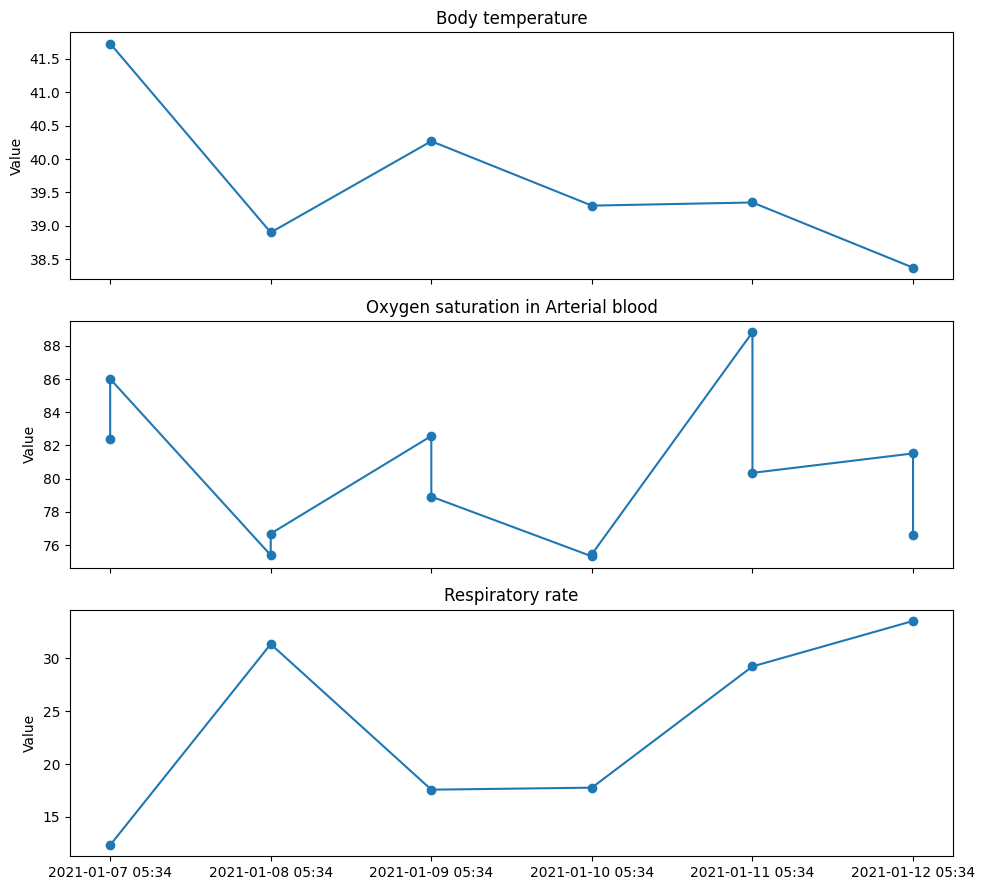

In [71]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# df = df_observations[df_observations.Observation.isin(['Oxygen saturation in Arterial blood', 'Total Cholesterol'])]#'Body temperature', 'Respiratory rate'])]
df = df_observations[df_observations.Observation.isin(['Oxygen saturation in Arterial blood', 'Body temperature', 'Respiratory rate'])]

# Convert the 'Recorded' column to datetime
# df['Recorded'] = pd.to_datetime(df['Recorded'], utc=True)
df['Recorded'] = df['Recorded'].astype(str).str[0:16].str.replace('T', ' ')

# Group by 'Observation'
grouped = df.groupby('Observation')

# Number of rows for subplots
num_rows = len(grouped)

# Create subplots
fig, axes = plt.subplots(num_rows, 1, figsize=(10, num_rows * 3), sharex=True)

# Iterate over each group and plot
for (name, group), ax in zip(grouped, axes):
    ax.plot(group['Recorded'], group['Value'], marker='o')
    ax.set_title(name)
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

In [ ]:
filesList = os.listdir('/kaggle/input/fhir-1ksample/fhir')


In [52]:
# https://www.kaggle.com/code/drscarlat/fhir-starter-parse-healthcare-bundles-into-tables
files_list = os.listdir('../../synthetic-clinical-notes/data_store/fhir-1ksample')

# !pip install fhir.resources

from fhir.resources.bundle import Bundle


f = open('../../synthetic-clinical-notes/data_store/fhir-1ksample/' +files_list[0],)
json_obj = json.load(f)

oneBundle = Bundle.parse_obj(json_obj)

ValidationError: 120 validation errors for Bundle
entry -> 1 -> resource -> address
  extra fields not permitted (type=value_error.extra)
entry -> 1 -> resource -> telecom
  extra fields not permitted (type=value_error.extra)
entry -> 3 -> resource -> class
  value is not a valid list (type=type_error.list)
entry -> 3 -> resource -> participant -> 0 -> individual
  extra fields not permitted (type=value_error.extra)
entry -> 3 -> resource -> period
  extra fields not permitted (type=value_error.extra)
entry -> 5 -> resource -> participant -> 0 -> role -> __root__
  Value is expected from the instance of <class 'fhir.resources.codeableconcept.CodeableConcept'>, but got type <class 'list'> (type=value_error)
entry -> 5 -> resource -> participant -> 1 -> role -> __root__
  Value is expected from the instance of <class 'fhir.resources.codeableconcept.CodeableConcept'>, but got type <class 'list'> (type=value_error)
entry -> 5 -> resource -> participant -> 2 -> role -> __root__
  Value is expected from the instance of <class 'fhir.resources.codeableconcept.CodeableConcept'>, but got type <class 'list'> (type=value_error)
entry -> 5 -> resource -> encounter
  extra fields not permitted (type=value_error.extra)
entry -> 5 -> resource -> reasonCode
  extra fields not permitted (type=value_error.extra)
entry -> 8 -> resource -> activity -> 0 -> detail
  extra fields not permitted (type=value_error.extra)
entry -> 8 -> resource -> activity -> 1 -> detail
  extra fields not permitted (type=value_error.extra)
entry -> 8 -> resource -> activity -> 2 -> detail
  extra fields not permitted (type=value_error.extra)
entry -> 8 -> resource -> activity -> 3 -> detail
  extra fields not permitted (type=value_error.extra)
entry -> 8 -> resource -> addresses -> 0 -> reference -> __root__
  Invalid json str value has been provided for class <class 'fhir.resources.reference.Reference'> (type=value_error)
entry -> 10 -> resource -> contained -> 1 -> __root__ -> kind
  field required (type=value_error.missing)
entry -> 11 -> resource -> address
  extra fields not permitted (type=value_error.extra)
entry -> 11 -> resource -> telecom
  extra fields not permitted (type=value_error.extra)
entry -> 13 -> resource -> class
  value is not a valid list (type=type_error.list)
entry -> 13 -> resource -> participant -> 0 -> individual
  extra fields not permitted (type=value_error.extra)
entry -> 13 -> resource -> period
  extra fields not permitted (type=value_error.extra)
entry -> 14 -> resource -> medication
  field required (type=value_error.missing)
entry -> 14 -> resource -> medicationCodeableConcept
  extra fields not permitted (type=value_error.extra)
entry -> 14 -> resource -> reasonReference
  extra fields not permitted (type=value_error.extra)
entry -> 17 -> resource -> contained -> 1 -> __root__ -> kind
  field required (type=value_error.missing)
entry -> 18 -> resource -> class
  value is not a valid list (type=type_error.list)
entry -> 18 -> resource -> participant -> 0 -> individual
  extra fields not permitted (type=value_error.extra)
entry -> 18 -> resource -> period
  extra fields not permitted (type=value_error.extra)
entry -> 21 -> resource -> participant -> 0 -> role -> __root__
  Value is expected from the instance of <class 'fhir.resources.codeableconcept.CodeableConcept'>, but got type <class 'list'> (type=value_error)
entry -> 21 -> resource -> participant -> 1 -> role -> __root__
  Value is expected from the instance of <class 'fhir.resources.codeableconcept.CodeableConcept'>, but got type <class 'list'> (type=value_error)
entry -> 21 -> resource -> participant -> 2 -> role -> __root__
  Value is expected from the instance of <class 'fhir.resources.codeableconcept.CodeableConcept'>, but got type <class 'list'> (type=value_error)
entry -> 21 -> resource -> encounter
  extra fields not permitted (type=value_error.extra)
entry -> 21 -> resource -> reasonCode
  extra fields not permitted (type=value_error.extra)
entry -> 27 -> resource -> activity -> 0 -> detail
  extra fields not permitted (type=value_error.extra)
entry -> 27 -> resource -> activity -> 1 -> detail
  extra fields not permitted (type=value_error.extra)
entry -> 27 -> resource -> addresses -> 0 -> reference -> __root__
  Invalid json str value has been provided for class <class 'fhir.resources.reference.Reference'> (type=value_error)
entry -> 29 -> resource -> contained -> 1 -> __root__ -> kind
  field required (type=value_error.missing)
entry -> 30 -> resource -> class
  value is not a valid list (type=type_error.list)
entry -> 30 -> resource -> participant -> 0 -> individual
  extra fields not permitted (type=value_error.extra)
entry -> 30 -> resource -> period
  extra fields not permitted (type=value_error.extra)
entry -> 30 -> resource -> reasonCode
  extra fields not permitted (type=value_error.extra)
entry -> 33 -> resource -> contained -> 1 -> __root__ -> kind
  field required (type=value_error.missing)
entry -> 34 -> resource -> class
  value is not a valid list (type=type_error.list)
entry -> 34 -> resource -> participant -> 0 -> individual
  extra fields not permitted (type=value_error.extra)
entry -> 34 -> resource -> period
  extra fields not permitted (type=value_error.extra)
entry -> 34 -> resource -> reasonCode
  extra fields not permitted (type=value_error.extra)
entry -> 36 -> resource -> medication
  field required (type=value_error.missing)
entry -> 36 -> resource -> medicationCodeableConcept
  extra fields not permitted (type=value_error.extra)
entry -> 36 -> resource -> reasonReference
  extra fields not permitted (type=value_error.extra)
entry -> 38 -> resource -> participant -> 0 -> role -> __root__
  Value is expected from the instance of <class 'fhir.resources.codeableconcept.CodeableConcept'>, but got type <class 'list'> (type=value_error)
entry -> 38 -> resource -> participant -> 1 -> role -> __root__
  Value is expected from the instance of <class 'fhir.resources.codeableconcept.CodeableConcept'>, but got type <class 'list'> (type=value_error)
entry -> 38 -> resource -> participant -> 2 -> role -> __root__
  Value is expected from the instance of <class 'fhir.resources.codeableconcept.CodeableConcept'>, but got type <class 'list'> (type=value_error)
entry -> 38 -> resource -> encounter
  extra fields not permitted (type=value_error.extra)
entry -> 38 -> resource -> reasonCode
  extra fields not permitted (type=value_error.extra)
entry -> 39 -> resource -> activity -> 0 -> detail
  extra fields not permitted (type=value_error.extra)
entry -> 39 -> resource -> activity -> 1 -> detail
  extra fields not permitted (type=value_error.extra)
entry -> 39 -> resource -> addresses -> 0 -> reference -> __root__
  Invalid json str value has been provided for class <class 'fhir.resources.reference.Reference'> (type=value_error)
entry -> 41 -> resource -> contained -> 1 -> __root__ -> kind
  field required (type=value_error.missing)
entry -> 42 -> resource -> class
  value is not a valid list (type=type_error.list)
entry -> 42 -> resource -> participant -> 0 -> individual
  extra fields not permitted (type=value_error.extra)
entry -> 42 -> resource -> period
  extra fields not permitted (type=value_error.extra)
entry -> 58 -> resource -> performedPeriod
  extra fields not permitted (type=value_error.extra)
entry -> 62 -> resource -> contained -> 1 -> __root__ -> kind
  field required (type=value_error.missing)
entry -> 63 -> resource -> class
  value is not a valid list (type=type_error.list)
entry -> 63 -> resource -> participant -> 0 -> individual
  extra fields not permitted (type=value_error.extra)
entry -> 63 -> resource -> period
  extra fields not permitted (type=value_error.extra)
entry -> 88 -> resource -> contained -> 1 -> __root__ -> kind
  field required (type=value_error.missing)
entry -> 89 -> resource -> class
  value is not a valid list (type=type_error.list)
entry -> 89 -> resource -> participant -> 0 -> individual
  extra fields not permitted (type=value_error.extra)
entry -> 89 -> resource -> period
  extra fields not permitted (type=value_error.extra)
entry -> 89 -> resource -> reasonCode
  extra fields not permitted (type=value_error.extra)
entry -> 92 -> resource -> contained -> 1 -> __root__ -> kind
  field required (type=value_error.missing)
entry -> 93 -> resource -> class
  value is not a valid list (type=type_error.list)
entry -> 93 -> resource -> participant -> 0 -> individual
  extra fields not permitted (type=value_error.extra)
entry -> 93 -> resource -> period
  extra fields not permitted (type=value_error.extra)
entry -> 109 -> resource -> performedPeriod
  extra fields not permitted (type=value_error.extra)
entry -> 114 -> resource -> contained -> 1 -> __root__ -> kind
  field required (type=value_error.missing)
entry -> 115 -> resource -> class
  value is not a valid list (type=type_error.list)
entry -> 115 -> resource -> participant -> 0 -> individual
  extra fields not permitted (type=value_error.extra)
entry -> 115 -> resource -> period
  extra fields not permitted (type=value_error.extra)
entry -> 142 -> resource -> performedPeriod
  extra fields not permitted (type=value_error.extra)
entry -> 147 -> resource -> contained -> 1 -> __root__ -> kind
  field required (type=value_error.missing)
entry -> 148 -> resource -> class
  value is not a valid list (type=type_error.list)
entry -> 148 -> resource -> participant -> 0 -> individual
  extra fields not permitted (type=value_error.extra)
entry -> 148 -> resource -> period
  extra fields not permitted (type=value_error.extra)
entry -> 168 -> resource -> performedPeriod
  extra fields not permitted (type=value_error.extra)
entry -> 173 -> resource -> contained -> 1 -> __root__ -> kind
  field required (type=value_error.missing)
entry -> 174 -> resource -> class
  value is not a valid list (type=type_error.list)
entry -> 174 -> resource -> participant -> 0 -> individual
  extra fields not permitted (type=value_error.extra)
entry -> 174 -> resource -> period
  extra fields not permitted (type=value_error.extra)
entry -> 193 -> resource -> contained -> 1 -> __root__ -> kind
  field required (type=value_error.missing)
entry -> 194 -> resource -> class
  value is not a valid list (type=type_error.list)
entry -> 194 -> resource -> participant -> 0 -> individual
  extra fields not permitted (type=value_error.extra)
entry -> 194 -> resource -> period
  extra fields not permitted (type=value_error.extra)
entry -> 210 -> resource -> performedPeriod
  extra fields not permitted (type=value_error.extra)
entry -> 214 -> resource -> contained -> 1 -> __root__ -> kind
  field required (type=value_error.missing)
entry -> 215 -> resource -> class
  value is not a valid list (type=type_error.list)
entry -> 215 -> resource -> participant -> 0 -> individual
  extra fields not permitted (type=value_error.extra)
entry -> 215 -> resource -> period
  extra fields not permitted (type=value_error.extra)
entry -> 240 -> resource -> contained -> 1 -> __root__ -> kind
  field required (type=value_error.missing)
entry -> 241 -> resource -> class
  value is not a valid list (type=type_error.list)
entry -> 241 -> resource -> participant -> 0 -> individual
  extra fields not permitted (type=value_error.extra)
entry -> 241 -> resource -> period
  extra fields not permitted (type=value_error.extra)
entry -> 241 -> resource -> reasonCode
  extra fields not permitted (type=value_error.extra)
entry -> 244 -> resource -> contained -> 1 -> __root__ -> kind
  field required (type=value_error.missing)
entry -> 245 -> resource -> class
  value is not a valid list (type=type_error.list)
entry -> 245 -> resource -> participant -> 0 -> individual
  extra fields not permitted (type=value_error.extra)
entry -> 245 -> resource -> period
  extra fields not permitted (type=value_error.extra)
entry -> 245 -> resource -> reasonCode
  extra fields not permitted (type=value_error.extra)
entry -> 248 -> resource -> contained -> 1 -> __root__ -> kind
  field required (type=value_error.missing)
entry -> 249 -> resource -> class
  value is not a valid list (type=type_error.list)
entry -> 249 -> resource -> participant -> 0 -> individual
  extra fields not permitted (type=value_error.extra)
entry -> 249 -> resource -> period
  extra fields not permitted (type=value_error.extra)
entry -> 276 -> resource -> performedPeriod
  extra fields not permitted (type=value_error.extra)
entry -> 281 -> resource -> contained -> 1 -> __root__ -> kind
  field required (type=value_error.missing)
entry -> 282 -> resource -> class
  value is not a valid list (type=type_error.list)
entry -> 282 -> resource -> participant -> 0 -> individual
  extra fields not permitted (type=value_error.extra)
entry -> 282 -> resource -> period
  extra fields not permitted (type=value_error.extra)
entry -> 298 -> resource -> performedPeriod
  extra fields not permitted (type=value_error.extra)
entry -> 302 -> resource -> contained -> 1 -> __root__ -> kind
  field required (type=value_error.missing)

In [48]:
files_list[0]

'Robert854_Botsford977_148ad83c-4dbc-4cb6-9334-44e6886f1e42.json'

In [49]:
os.listdir('../../synthetic-clinical-notes/data_store/')

['A&E Synethetic Data', '.DS_Store', 'fhir-1ksample', 'coherent-11-07-2022']